In [1]:
from utilities import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import reproject
import radio_beam
import os
from astropy.convolution import convolve
from astropy.io import fits
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='SgrB2S'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'SgrB2S':'/mar2025_2_removesDS2exclusions/','DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                        'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/{ch3oh_sourcedict[source]}'

In [2]:
path_nh2=ch3oh_datadir+'bootstrap_nh2map_3sigma_bolocamfeather_smoothedtobolocam.fits'
path_error_nh2=ch3oh_datadir+'bootstrap_nh2map_error_bolocamfeather_smoothedtobolocam.fits'

path_nc2h5oh=c2h5oh_datadir+'ntotmap_allspw_withnans_weighted_useintercept_3sigma.fits'
path_error_nc2h5oh=c2h5oh_datadir+'ntoterrmap_allspw_withnans_weighted_useintercept.fits'

path_nch3oh=ch3oh_datadir+'bootstrap_ntot_intstd_boostrap1000_nonegativeslope.fits'
path_error_nch3oh=ch3oh_datadir+'ntoterrmap_allspw_withnans_weighted_useintercept.fits'

In [3]:
hdu_nh2=fits.open(path_nh2)
beam_nh2=radio_beam.Beam.from_fits_header(hdu_nh2[0].header)
data_nh2=hdu_nh2[0].data
error_nh2=fits.getdata(path_error_nh2)
nh2wcs=WCS(hdu_nh2[0].header)

hdu_nc2h5oh=fits.open(path_nc2h5oh)
beam_nc2h5oh=radio_beam.Beam.from_fits_header(hdu_nc2h5oh[0].header)
data_nc2h5oh=hdu_nc2h5oh[0].data

hdu_error_nc2h5oh=fits.open(path_error_nc2h5oh)
beam_error_nc2h5oh=radio_beam.Beam.from_fits_header(hdu_error_nc2h5oh[0].header)
error_nc2h5oh=hdu_error_nc2h5oh[0].data

beam_deconv=beam_nh2.deconvolve(beam_nc2h5oh)
pixscale=WCS(hdu_nc2h5oh[0].header).proj_plane_pixel_area()**0.5
okmask=np.isfinite(data_nc2h5oh)*np.isfinite(data_nh2)

smoothed_nc2h5oh = convolve(data_nc2h5oh, beam_deconv.as_kernel(pixscale),nan_treatment='interpolate')
okmasknc2h5oh=np.ma.masked_where(okmask==False,smoothed_nc2h5oh)
ok_smoothed_nc2h5oh=okmasknc2h5oh.filled(fill_value=np.nan)

preconvolve_ok_error_nc2h5oh=okmask*error_nc2h5oh

smoothed_error_nc2h5oh = convolve(preconvolve_ok_error_nc2h5oh, beam_deconv.as_kernel(pixscale),nan_treatment='interpolate')#,mask=okmask,preserve_nan=True)
okmaskerrornc2h5oh=np.ma.masked_where(okmask==False,smoothed_error_nc2h5oh)
ok_smoothed_error_nc2h5oh=okmaskerrornc2h5oh.filled(fill_value=np.nan)

xc2h5oh=ok_smoothed_nc2h5oh/data_nh2
error_xc2h5oh=np.sqrt(((1/data_nh2)*(ok_smoothed_error_nc2h5oh))**2+((-ok_smoothed_nc2h5oh/(data_nh2**2))*(error_nh2))**2)
snr_xc2h5oh=xc2h5oh/error_xc2h5oh
sigmamask=(snr_xc2h5oh >= 3)
sigma3_xc2h5oh=xc2h5oh * sigmamask * (xc2h5oh <= 6e-7)#1e-6)#2e-7#1e-6)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
np.nanmax(sigma3_xc2h5oh)

5.230572019585249e-07

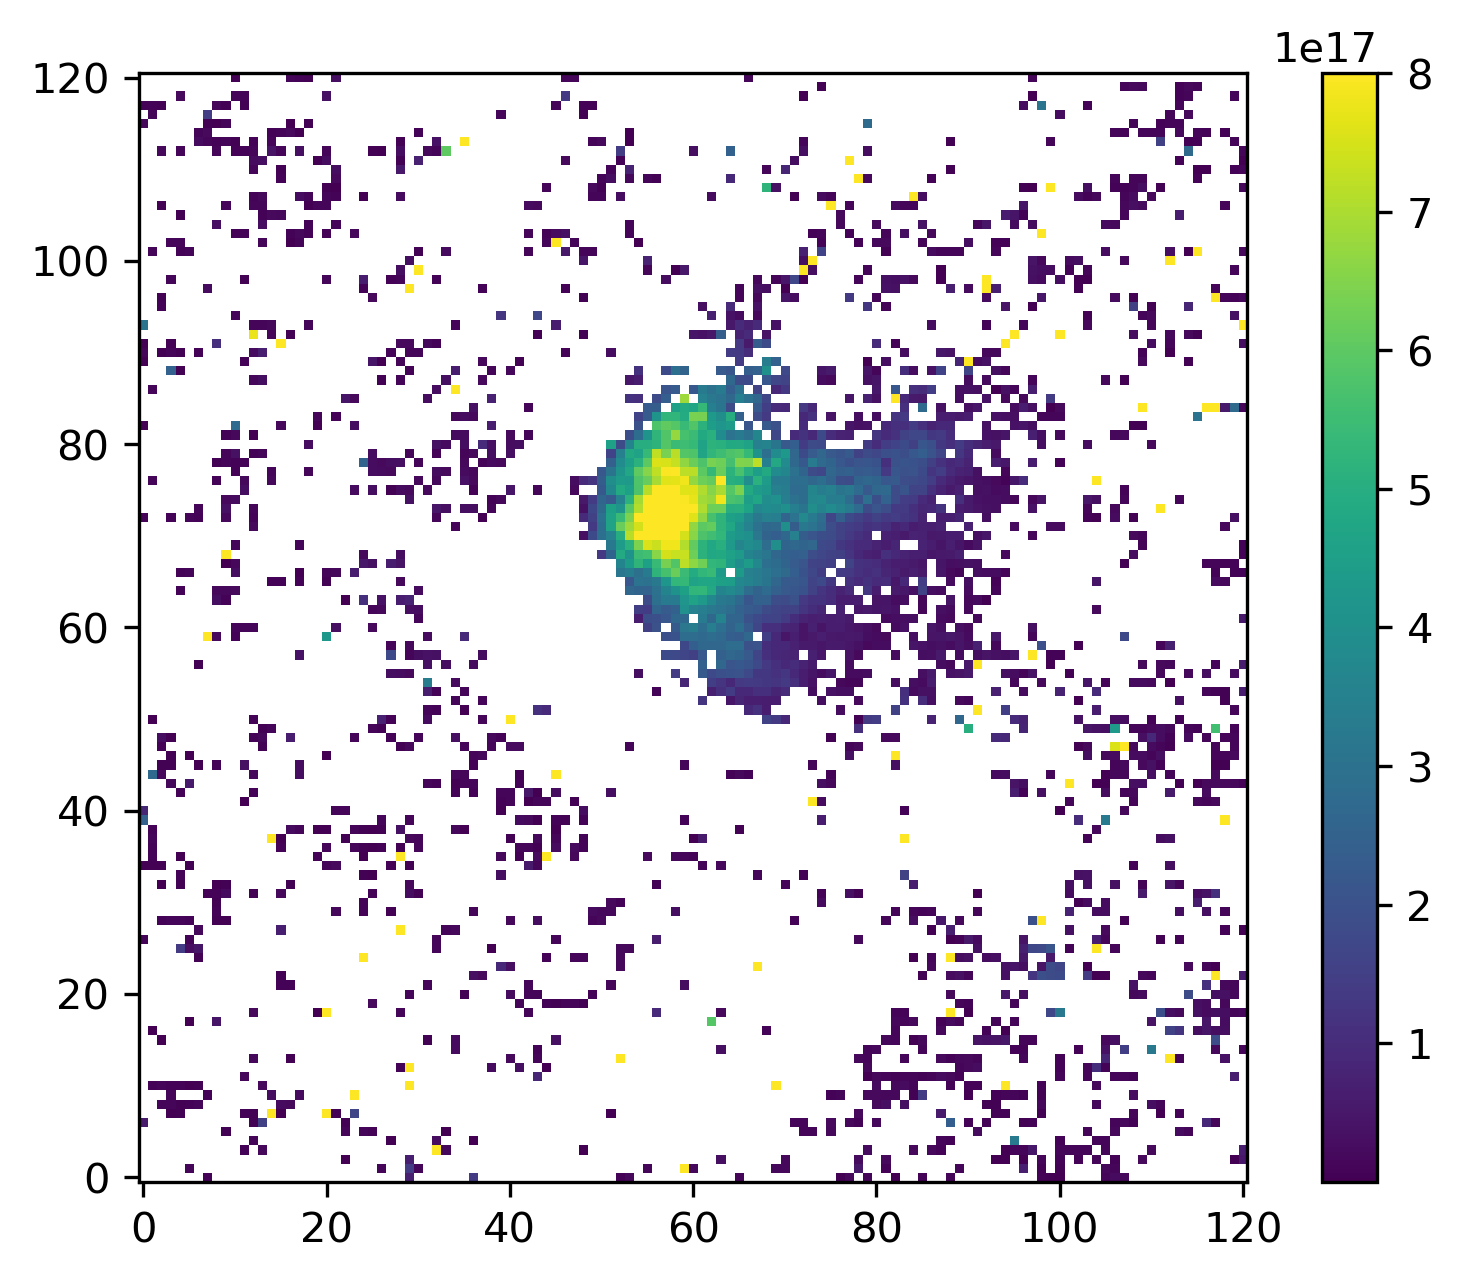

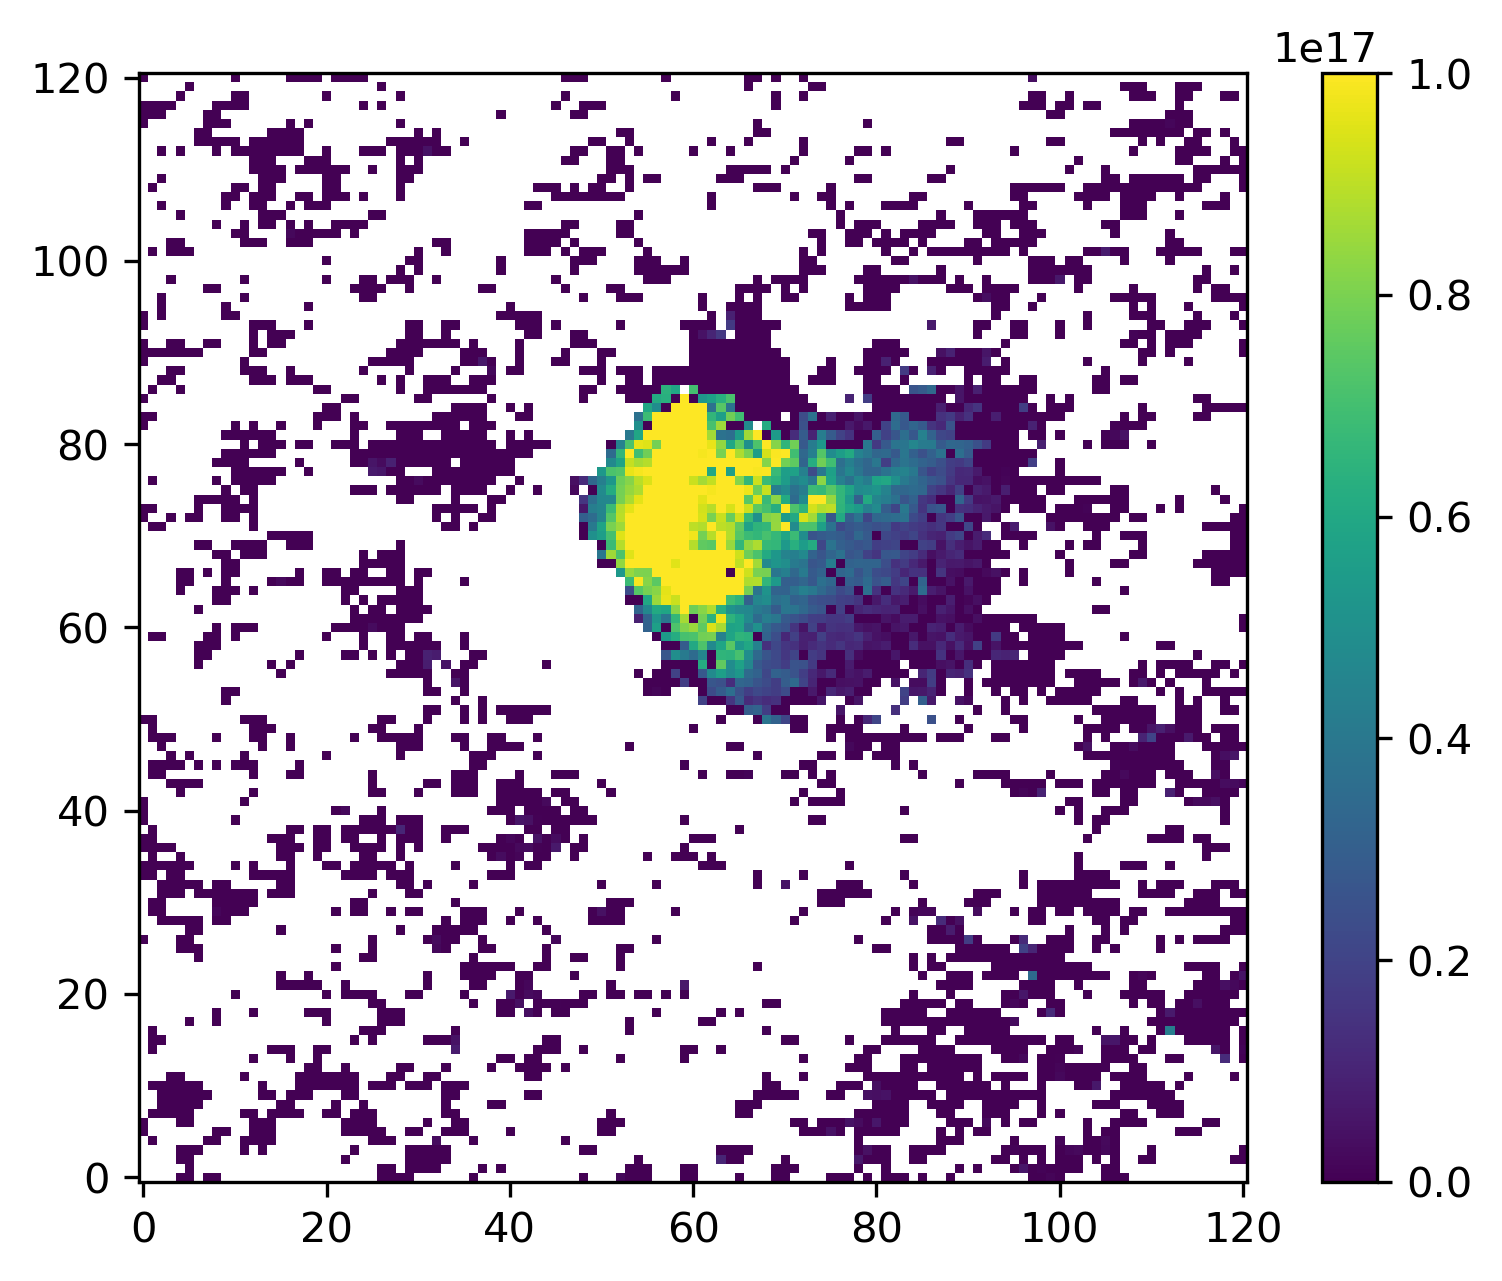

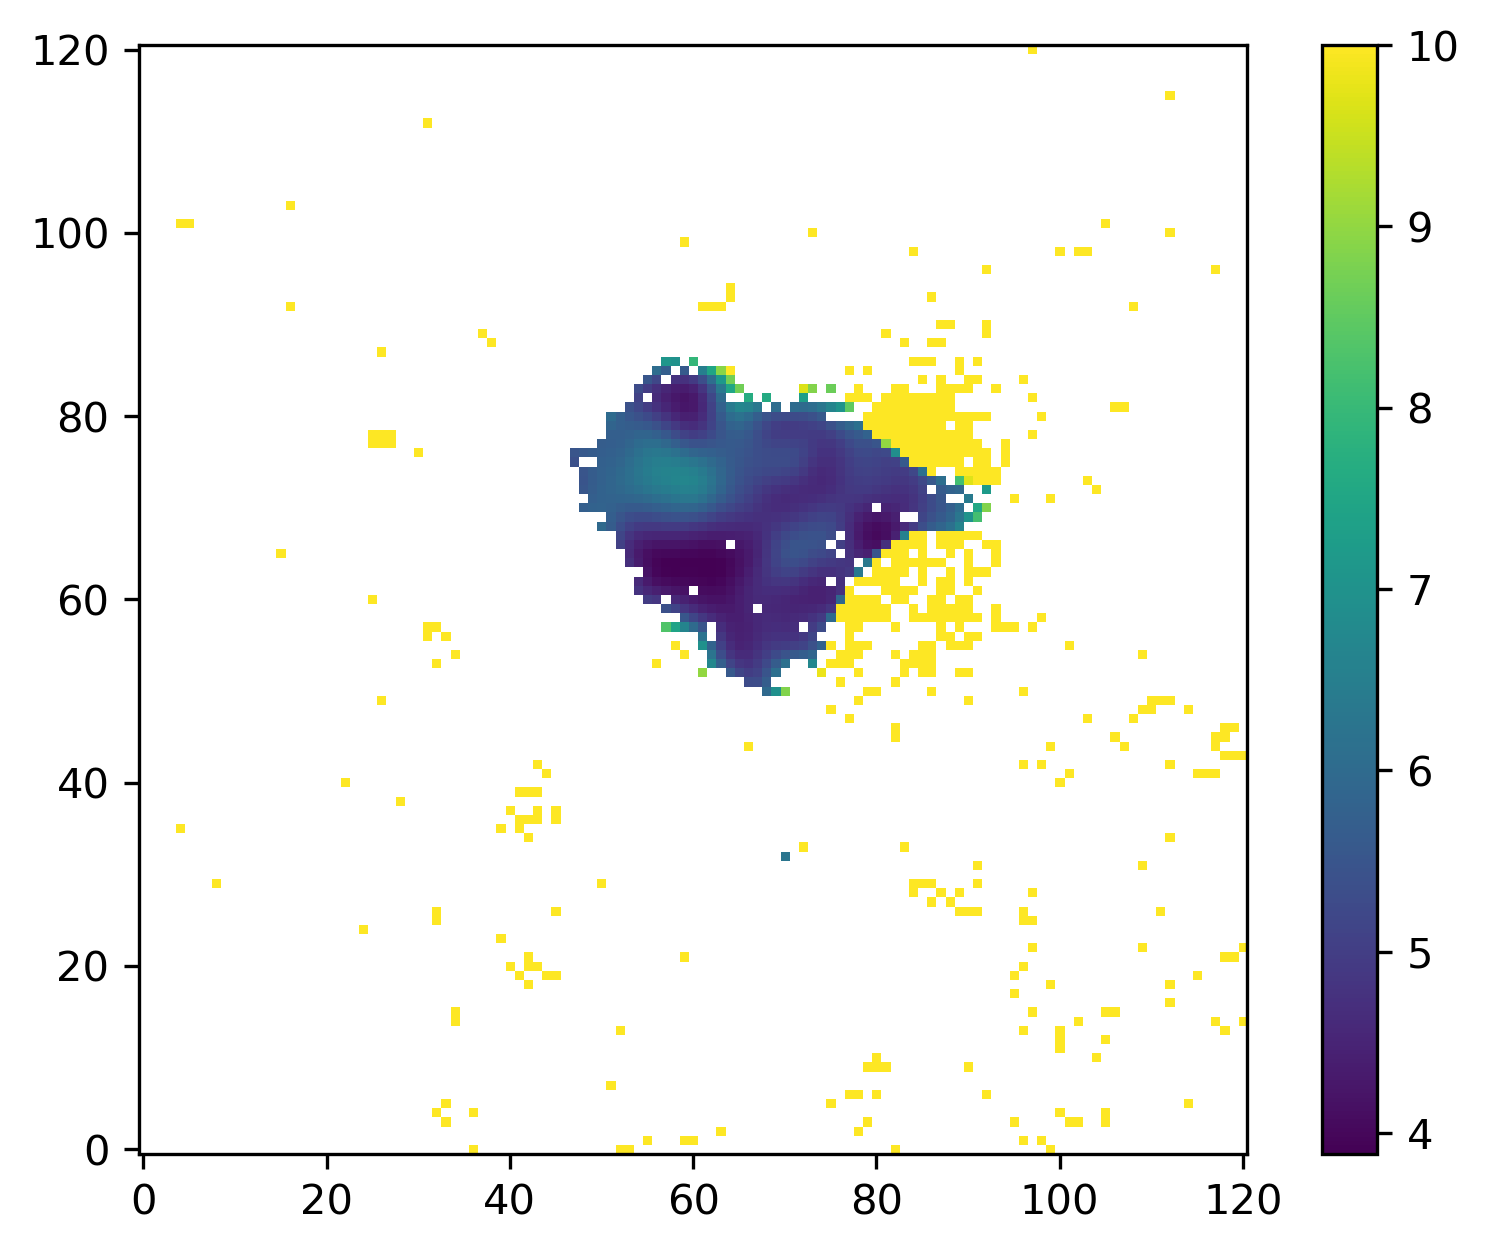

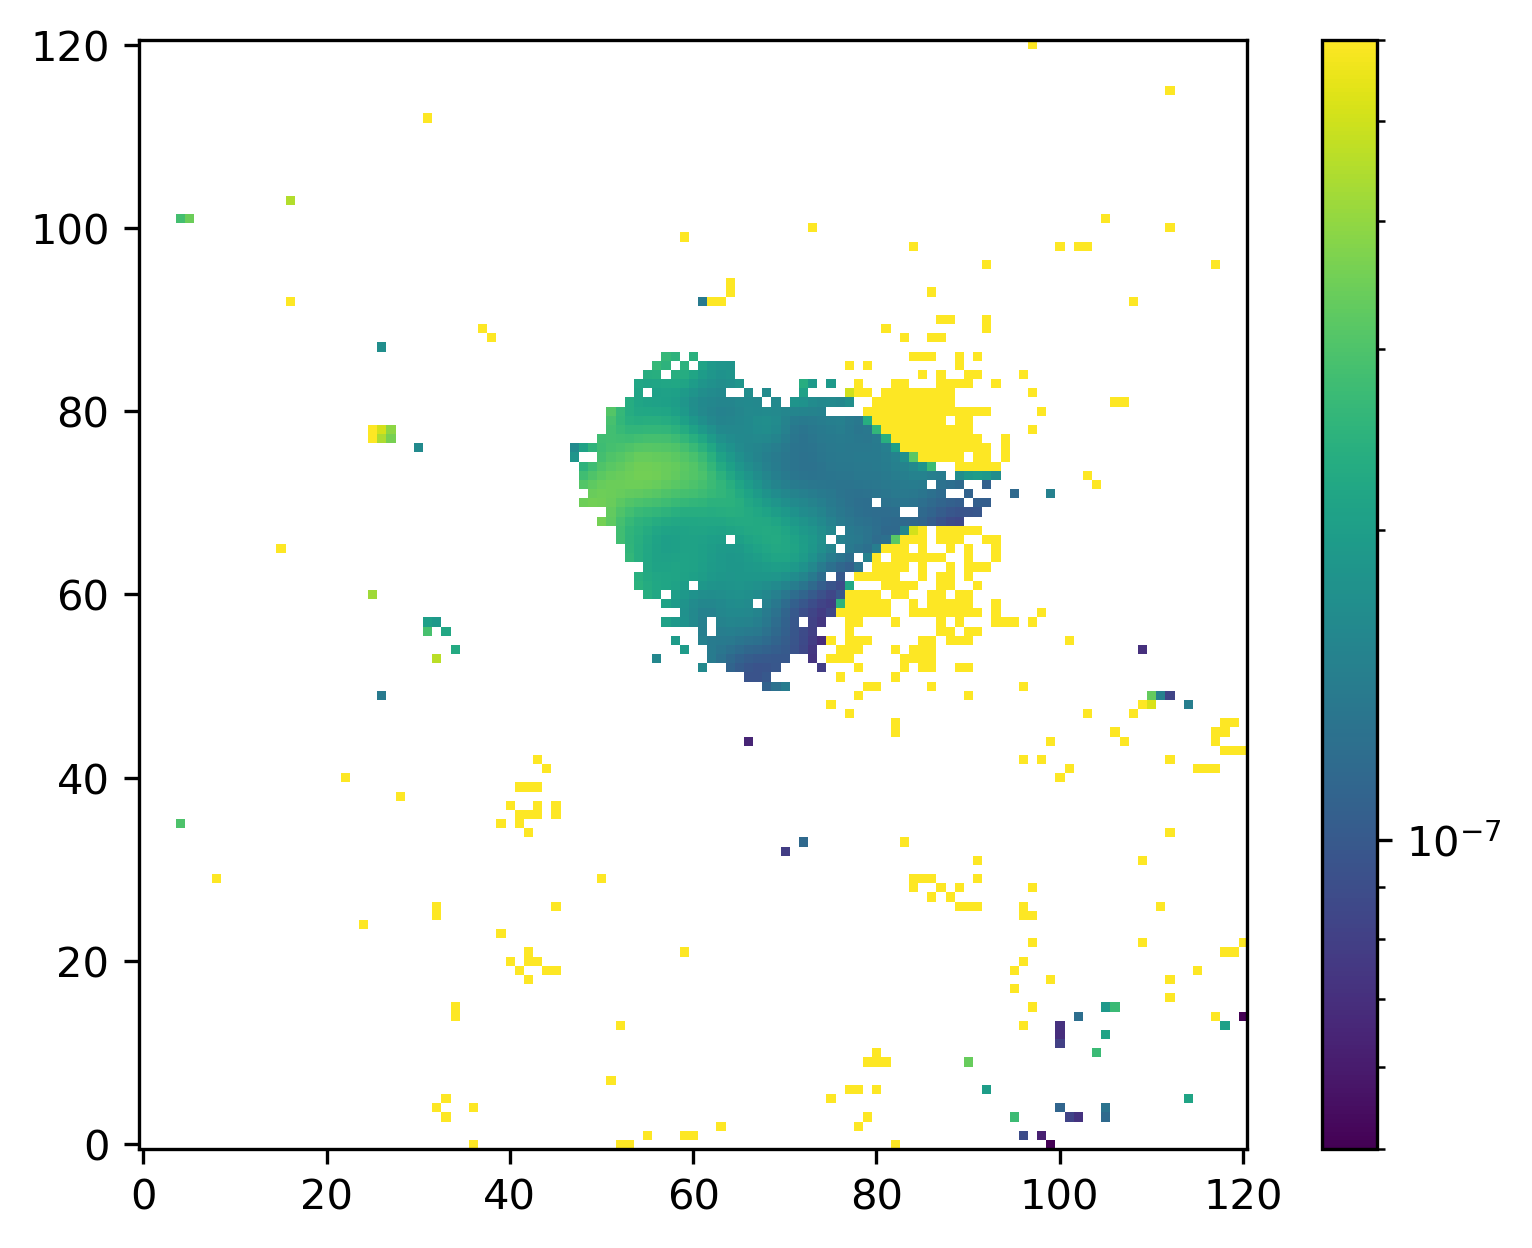

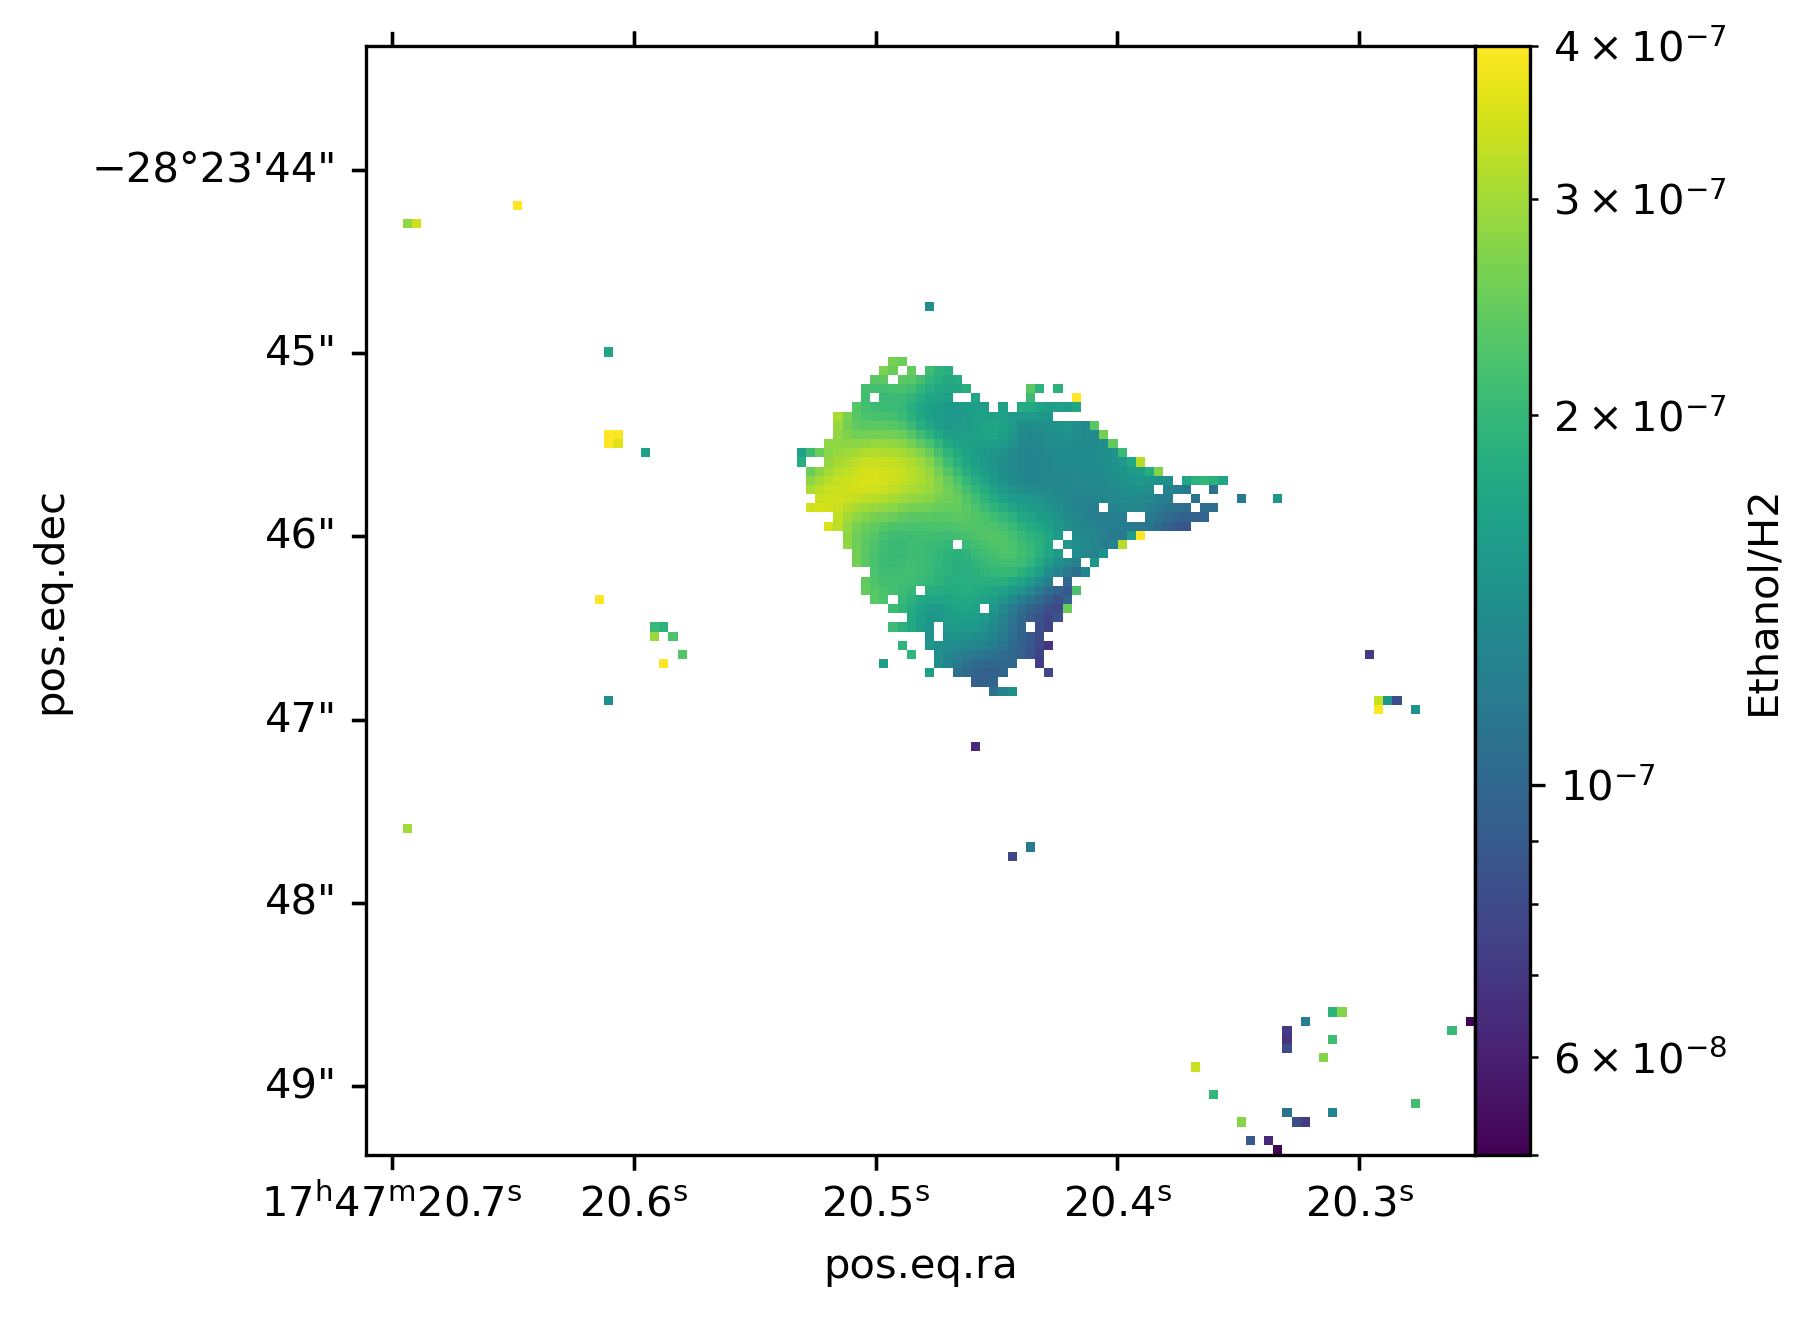

"\nplt.imshow(data_nh2,origin='lower',vmax=1.75e24)\nplt.colorbar()\nplt.show()\n"

In [5]:
plt.imshow(data_nc2h5oh,origin='lower',vmax=8e17)
plt.colorbar()
plt.show()

plt.imshow(preconvolve_ok_error_nc2h5oh,origin='lower',vmax=1e17)
plt.colorbar()
plt.show()
plt.imshow((ok_smoothed_nc2h5oh/ok_smoothed_error_nc2h5oh),origin='lower',vmax=10)
plt.colorbar()
plt.show()
plt.imshow(xc2h5oh,origin='lower',norm=mpl.colors.LogNorm(vmin=5e-8,vmax=6e-7))
plt.colorbar()
plt.show()

sliced=['x','y']#,0,0]#Must be in same order as axes are given in fits header, at least. 
plt.figure()
ax=plt.subplot(projection=nh2wcs,slices=sliced)
ra=ax.coords[0]
dec=ax.coords[1]

img=ax.imshow(sigma3_xc2h5oh,origin='lower',norm=mpl.colors.LogNorm(vmin=5e-8,vmax=4e-7))
plt.colorbar(img,label='Ethanol/H2',pad=0)
plt.show()
'''
plt.imshow(data_nh2,origin='lower',vmax=1.75e24)
plt.colorbar()
plt.show()
'''

In [6]:
sigma3_c2h5ohabundprimaryhdu=fits.PrimaryHDU(sigma3_xc2h5oh)
sigma3_c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
sigma3_c2h5ohabundprimaryhdu.header['BTYPE']='N(C2H5OH)/N(H2)'
sigma3_c2h5ohabundprimaryhdu.header['BUNIT']='cm-2/cm-2'
sigma3_c2h5ohabundhdul=fits.HDUList([sigma3_c2h5ohabundprimaryhdu])
sigma3_c2h5ohabundfitspath=c2h5oh_datadir+f'Xc2h5oh_3sigma_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving 3sigma C2H5OH abundance map at {sigma3_c2h5ohabundfitspath}\n')
sigma3_c2h5ohabundhdul.writeto(sigma3_c2h5ohabundfitspath,overwrite=True)

c2h5ohabundprimaryhdu=fits.PrimaryHDU(xc2h5oh)
c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
c2h5ohabundprimaryhdu.header['BTYPE']='N(C2H5OH)/N(H2)'
c2h5ohabundprimaryhdu.header['BUNIT']='cm-2/cm-2'
c2h5ohabundhdul=fits.HDUList([c2h5ohabundprimaryhdu])
c2h5ohabundfitspath=c2h5oh_datadir+f'Xc2h5oh_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving C2H5OH abundance map at {c2h5ohabundfitspath}\n')
c2h5ohabundhdul.writeto(c2h5ohabundfitspath,overwrite=True)

errc2h5ohabundprimaryhdu=fits.PrimaryHDU(error_xc2h5oh)
errc2h5ohabundprimaryhdu.header=hdu_nh2[0].header
errc2h5ohabundprimaryhdu.header['BTYPE']='Abundance error (C2H5OH/H2)'
errc2h5ohabundprimaryhdu.header['BUNIT']='cm-2/cm-2'
errc2h5ohabundhdul=fits.HDUList([errc2h5ohabundprimaryhdu])
errc2h5ohabundfitspath=c2h5oh_datadir+f'Xc2h5oh_error_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving C2H5OH abundance error map at {errc2h5ohabundfitspath}\n')
errc2h5ohabundhdul.writeto(errc2h5ohabundfitspath,overwrite=True)

Saving 3sigma C2H5OH abundance map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field1/C2H5OH/SgrB2S/mar2025_2_removesDS2exclusions/Xc2h5oh_3sigma_bolocamfeather_smoothedtobolocam.fits

Saving C2H5OH abundance map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field1/C2H5OH/SgrB2S/mar2025_2_removesDS2exclusions/Xc2h5oh_bolocamfeather_smoothedtobolocam.fits

Saving C2H5OH abundance error map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field1/C2H5OH/SgrB2S/mar2025_2_removesDS2exclusions/Xc2h5oh_error_bolocamfeather_smoothedtobolocam.fits

